# Transmission

In [1]:
%matplotlib inline
import numpy as np
np.seterr(divide='ignore') # Ignore divide by zero in log plots
from scipy import signal
import scipy.signal
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import skrf as rf # pip install scikit-rf if you want to run this one

First, let's set up a traditional, full-precision modulator and plot the spectrum of that as a baseline

In [2]:
def prbs(n=0, taps=[]):
    state = [1]*n
    shift = lambda s: [sum([s[i] for i in taps]) % 2] + s[0:-1]
    out = []
    for i in range(2**n - 1):
        out.append(state[-1])
        state = shift(state)
    return out
prbs9 = lambda: prbs(n=9, taps=[4,8])

def make_carrier(freq=None, sample_rate=None, samples=None, phase=0):
  t = (1/sample_rate)*np.arange(samples)
  return np.real(np.exp(1j*(2*np.pi*freq*t - phase)))

def modulate_gmsk(bits, carrier_freq=2.402e9, sample_rate=5e9, baseband=False):
    symbol_rate = 1e6 # 1Mhz
    BT = 0.5
    bw = symbol_rate*BT/sample_rate

    samples_per_symbol = int(sample_rate/symbol_rate)
    
    # This looks scary but it's just a traditional gaussian distribution from wikipedia
    kernel = np.array([(np.sqrt(2*np.pi/np.log(2))*bw)*np.exp(-(2/np.log(2))*np.power(np.pi*t*bw, 2)) for t in range(-5000,5000)])
    kernel /= sum(kernel) # Normalize so things amplitude after convolution remains the same
    
    rotation = np.repeat(bits, sample_rate/symbol_rate)*2.0 - 1.0
    smoothed_rotation = np.convolve(rotation, kernel,mode='same')

    angle_per_sample = (np.pi/2.0)/(samples_per_symbol)
    current_angle = 0
    modulated = np.zeros((len(smoothed_rotation),), dtype=np.complex64) # Represents I and Q as a complex number
    i = 0
    for bit in smoothed_rotation:
      current_angle += angle_per_sample*bit
      modulated[i] = np.exp(1j*current_angle)
      i += 1

    if baseband:
        return modulated
    
    I = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=0)
    Q = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=np.pi/2)

    return np.real(modulated)*I + np.imag(modulated)*Q

Now let's look at the FFT of this...

(-40.0, 0.0)

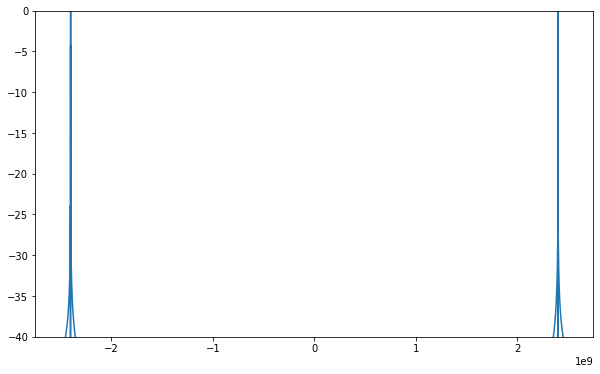

In [3]:
sample_rate = 5e9
modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)

fftm = np.abs(fft(modulated))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

This is clean (as one would expect), now let's see what happens if we reduce things to 1-bit of precision by just rounding

# The Naive Approach (Rounding)

(-40.0, 0.0)

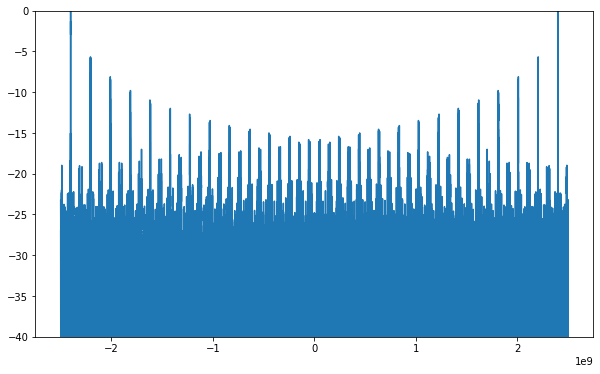

In [4]:
modulates5 = modulated = modulate_gmsk(prbs9(), sample_rate=5e9)

sample_rate=5e9

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

_Oof_ this is not pretty. What's happening here is that (I think) the aliases are mixing with each other to produce these interference paterns. In this case, it looks like the big subharmonics are spaced about 200Mhz which makes sense given the alias of 2.402ghz at 2.698ghz when sampling at 2.5ghz.

(-40.0, 0.0)

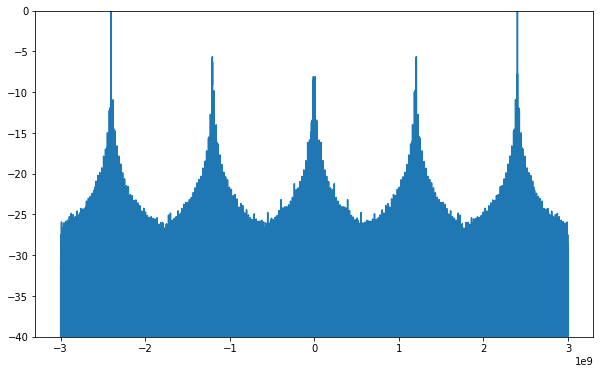

In [5]:
sample_rate = 6e9

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

Ok, in this case, the alias is at `3 + (3 - 2.402) = 3.6ghz`. The difference between this and 2.402ghz is about 1.2ghz, which looking at the next big peak, looks to be about 1.2ghz, so this makes sense. From this math, we can intuit that it's a good idea for the sample rate to be a whole number multiple of the carrier frequency. In the ideal case, 4 times the carrier:

(-40.0, 0.0)

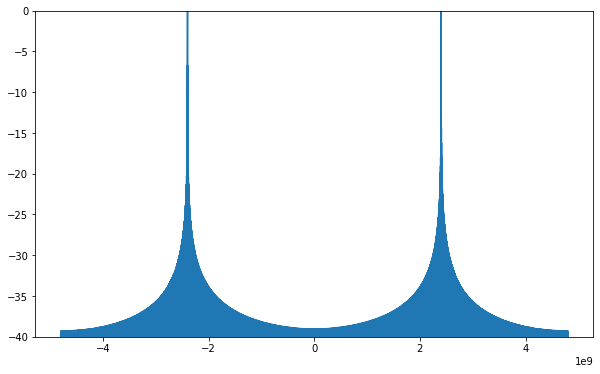

In [6]:
sample_rate = 2.402e9*4

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

There a couple of challenges here, however:

1. In order to get the clean(ish) spectrum, we have to clock the output frequency at a rate relative to the carrier frequency. If we only intended to use one frequency, this would be fine but Bluetooth (as an example) hops around frequency constantly by design. This might be doable, but it's kind of painful (this might require various SERDES resets which aren't instantaneous)
2. At 2.402ghz, 4x this would be... 9.6ghz, which is too fast for my (low-end-ish) SERDES which maxes out around 6ghz.

# Delta Sigma Modulation

A way around this is to use something called Delta Sigma Modulation. The way to think about this conceptually is that we keep a running sum of values we've output (think of this as the error) and factor this into the value we decide to output (versus just blindly rounding the current value)

In [7]:
def pwm2(sig, k=1.0):
  z1 = 0.0
  z2 = 0.0
  out = np.zeros((len(sig,)))

  for i in range(len(sig)):
    v = sig[i] - (k*z1 + z2)
    out[i] = np.sign(v)
    z2 = z1
    z1 = v - out[i]

  return out

To be clear, `pwm2` is replacing `np.sign`

(-40.0, 0.0)

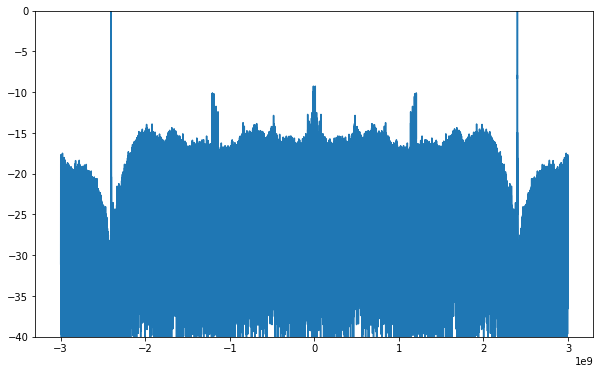

In [8]:
sample_rate = 6e9

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)
modulatedsd5 = modulated = pwm2(modulated, k=-2.0*np.cos(2.0*np.pi*2.402e9/sample_rate))

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

Now, even at this noise level, it's probably not a great idea to be pumping out -10dbm (assuming a 0dbm carrier) at 1.2ghz out of or antenna (see: FCC rules). So any real-world use of this would require an additional (analog) filter in between the transmitter and the antenna. This is generally called a "reconstruction filter" I'm assuming because it filters out the noise and restores the originally intended signal.

Given this, the actual output of the antenna is the cascaded spectrum with this output filter. It makes sense to design our sigma delta modulator with the knowledge of the filter we're going to slap on the end of it. In my case I have the delightfully named "DEA252450BT-2027A1" which is a surface mount part which has a frequency response of:

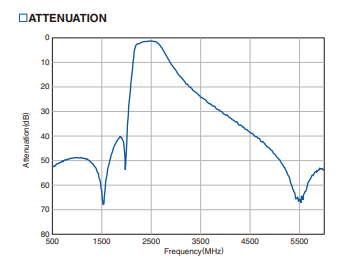

So in essense, we want a noise shaping filter that is more or less the inverse of this filter. But actually this picture isn't full descriptive of our filter because it shows only magnitude (not phase), so we can't fully simulate the effects of this filter.

To (more fully) characterize this filter, I hooked it up to a NanoVNA2 and saved its S parameters using a NanoVNA Saver:

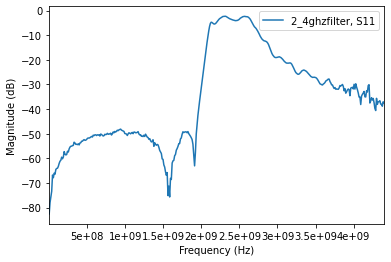

In [9]:
filter2_4 = rf.Network('2_4ghzfilter.s2p')
filter2_4.s21.plot_s_db()

Hey that's not too far off from data sheet (at least up to 4.4Ghz). 

Now, we're going to use a python package called PyDSM which will optimize a sigma delta NTF to this filter output. For whatever reason this package takes in an impulse response to optimize against (it appears it can do a noise weighting input but I'm unclear of the format there)

Timestep 3.2641464908425124e-11 seconds, frequency 3.063588e+10 hz


(0.0, 300.0)

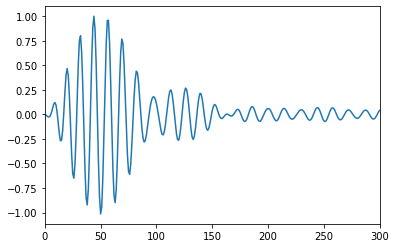

In [10]:
ts, ms = filter2_4.s21.impulse_response()
impulse_response = ms[list(ts).index(0):]
impulse_response = impulse_response/np.max(impulse_response)
tstep = ts[1] - ts[0]
print("Timestep {} seconds, frequency {:e} hz".format(tstep, 1/tstep))
plt.plot(impulse_response)
plt.gca().set_xlim(0, 300)

This is great and all but the impulse response is sampled at north of 30ghz (!). Our output serdes runs at around 6ghz so let's resample this to that rate

274


(0.0, 50.0)

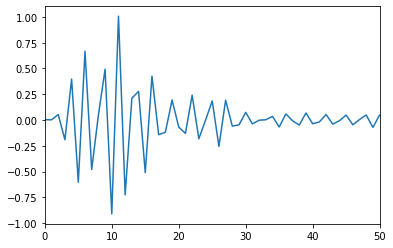

In [11]:
# Truncate the impulse response so we can get relatively close to 6ghz
trunc = impulse_response[:-4]
size = int((tstep*(len(trunc) - 1))/(1/6e9) + 1)
print(size)

impulse_response_6g = scipy.signal.resample(impulse_response, size)
plt.plot(impulse_response_6g)
plt.gca().set_xlim(0, 50)

Not quite as pretty, but it's what we need. Now let's use pydsm to fit a Noise Transfer Function that's more or less the inverse of this filter (so that they compliment one another)

In [12]:
from pydsm.ir import impulse_response
from pydsm.delsig import synthesizeNTF, simulateDSM, evalTF
from pydsm.delsig import dbv, dbp
from pydsm.NTFdesign import quantization_noise_gain
from pydsm.NTFdesign.legacy import q0_from_filter_ir
from pydsm.NTFdesign.weighting import ntf_fir_from_q0

H_inf = 1.5
q0 = q0_from_filter_ir(49, impulse_response_6g)
ntf_opti = ntf_fir_from_q0(q0, H_inf=H_inf)


Calling CVXOPT ...
     pcost       dcost       gap    pres   dres   k/t
 0:  2.7990e-17 -1.0000e+00  1e+02  8e+00  1e+01  1e+00
 1: -3.6109e-02  3.1817e-02  1e+01  1e+00  2e+00  4e-01
 2:  1.7741e-01  1.5919e-01  2e+00  2e-01  3e-01  4e-02
 3:  1.4325e-01  1.3608e-01  4e-01  9e-02  1e-01  2e-02
 4:  1.4744e-01  1.4441e-01  1e-01  3e-02  4e-02  5e-03
 5:  1.3596e-01  1.3446e-01  4e-02  1e-02  2e-02  2e-03
 6:  1.3486e-01  1.3401e-01  2e-02  6e-03  7e-03  6e-04
 7:  1.3313e-01  1.3283e-01  5e-03  2e-03  3e-03  2e-04
 8:  1.3241e-01  1.3234e-01  1e-03  4e-04  5e-04  4e-05
 9:  1.3233e-01  1.3229e-01  5e-04  2e-04  3e-04  2e-05
10:  1.3224e-01  1.3223e-01  1e-04  4e-05  5e-05  3e-06
11:  1.3223e-01  1.3223e-01  5e-05  2e-05  2e-05  8e-07
12:  1.3223e-01  1.3223e-01  4e-05  1e-05  2e-05  7e-07
13:  1.3222e-01  1.3222e-01  1e-05  4e-06  5e-06  2e-07
14:  1.3222e-01  1.3222e-01  9e-06  3e-06  4e-06  1e-07
15:  1.3222e-01  1.3222e-01  1e-06  4e-07  5e-07  2e-08
16:  1.3222e-01  1.3222e-01  5

Let's see how well we did. Anecdotally, this is not a _great_ solution but I'd wager this is because the oversampling rate is super low.

Text(0.5, 0.98, 'Output filter and NTFs')

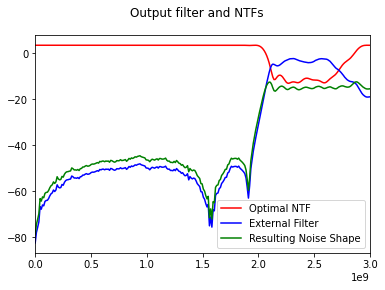

In [13]:
# Take the frequency response
samples = filter2_4.s21.s_db[:,0,0]
# Normalize the samples
ff = filter2_4.f/6e9

# Compute frequency response data
resp_opti = evalTF(ntf_opti, np.exp(1j*2*np.pi*ff))

# Plot the output filter, 
plt.figure()
plt.plot(ff*6e9, dbv(resp_opti), 'r', label="Optimal NTF")
plt.plot(ff*6e9, samples, 'b', label="External Filter")
plt.plot(ff*6e9, dbv(resp_opti) + samples, 'g', label="Resulting Noise Shape")
plt.gca().set_xlim(0, 3e9)
plt.legend(loc="lower right")
plt.suptitle("Output filter and NTFs")

Ok, so it's not amazing but definitely an improvement. But now that we've got this monstrous 49 coefficient NTF, how do we modulate with it?

In [14]:
sample_rate = 6e9
modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)
xx_opti = simulateDSM(modulated, ntf_opti)

(0.0, 3000000000.0)

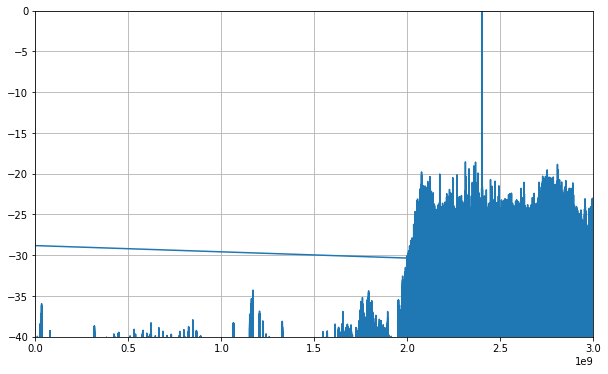

In [20]:
fftm = np.abs(fft(np.convolve(xx_opti[0], impulse_response_6g, mode="same")))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(fftm), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.grid(b=True)
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(0, 3e9)

(0.0, 3000000000.0)

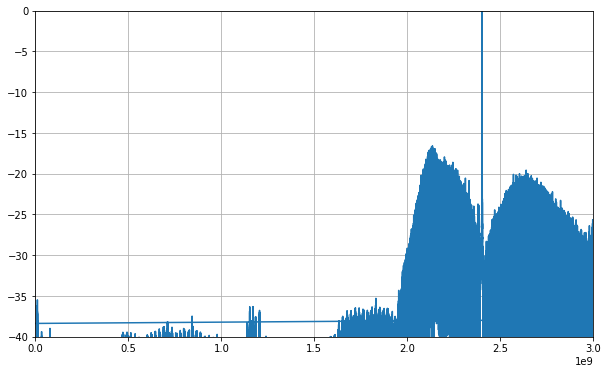

In [21]:
fftm = np.abs(fft(np.convolve(modulatedsd5, impulse_response_6g, mode="same")))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(fftm), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.grid(b=True)
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(0, 3e9)

How do we do this? Well, fortunately we're not the first to think of this and those who have thought of this even put together a nice package called [PyDSM](https://pypi.org/project/pydsm/). Let's install it and design some filters with it!

In [24]:
opt_power = np.var(np.convolve(xx_opti[0], impulse_response_6g, mode="same"))
orig_power = np.var(np.convolve(modulatedsd5, impulse_response_6g, mode="same"))
print(opt_power, orig_power)

12.868409476176861 11.639275222860583
